In [1]:
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np


# If there's a GPU available...
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/new-stg/home/banghua/anaconda3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-30 13:40:43.402898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 13:40:43.435714: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 13:40:43.435740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


In [2]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_train = pd.read_csv("~/med264/Dataset1/day1_30mortality_train.csv", index_col=0)
num_train_pos = df_train[df_train['Label'] == 1].shape[0]
num_train_neg = df_train[df_train['Label'] == 0].shape[0]
num_balanced = min(num_train_pos, num_train_neg)
df_train_pos = df_train[df_train['Label'] == 1].sample(n=num_balanced, random_state=42)
df_train_neg = df_train[df_train['Label'] == 0].sample(n=num_balanced, random_state=42)
df_train = pd.concat([df_train_pos, df_train_neg])

df_val = pd.read_csv("~/med264/Dataset1/day1_30mortality_val.csv", index_col=0)
num_val_pos = df_val[df_val['Label'] == 1].shape[0]
num_val_neg = df_val[df_val['Label'] == 0].shape[0]
num_balanced = min(num_val_pos, num_val_neg)
df_val_pos = df_val[df_val['Label'] == 1].sample(n=num_balanced, random_state=42)
df_val_neg = df_val[df_val['Label'] == 0].sample(n=num_balanced, random_state=42)
df_val = pd.concat([df_val_pos, df_val_neg])

df_test = pd.read_csv("~/med264/Dataset1/day1_30mortality_test.csv", index_col=0)
num_test_pos = df_test[df_test['Label'] == 1].shape[0]
num_test_neg = df_test[df_test['Label'] == 0].shape[0]
num_balanced = min(num_test_pos, num_test_neg)
df_test_pos = df_test[df_test['Label'] == 1].sample(n=num_balanced, random_state=42)
df_test_neg = df_test[df_test['Label'] == 0].sample(n=num_balanced, random_state=42)
df_test = pd.concat([df_test_pos, df_test_neg])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print('Number of validation sentences: {:,}\n'.format(df_val.shape[0]))
print('Number of testing sentences: {:,}\n'.format(df_test.shape[0]))

# Get the lists of sentences and their labels.
sentences_train = df_train.TEXT.values
labels_train = df_train.Label.values
sentences_val = df_val.TEXT.values
labels_val = df_val.Label.values
sentences_test = df_test.TEXT.values
labels_test = df_test.Label.values

Number of training sentences: 26,108

Number of validation sentences: 3,100

Number of testing sentences: 3,246



In [3]:
from transformers import BertTokenizer
import os
model_path = os.path.expanduser('~/med264/clinicalBERTs/pretraining_checkpoint/')
# Load the BERT tokenizer.
print('Loading BertTokenizer tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_path)

Loading BertTokenizer tokenizer...


In [4]:
from tqdm import tqdm
import os
import pickle
from keras.preprocessing.sequence import pad_sequences


# Correct the path by expanding the tilde to the user's home directory
file_path_train = os.path.expanduser('~/med264/Dataset3/input_ids_train.pickle')
file_path_valid = os.path.expanduser('~/med264/Dataset3/input_ids_valid.pickle')
file_path_test = os.path.expanduser('~/med264/Dataset3/input_ids_test.pickle')


input_ids_train, input_ids_valid, input_ids_test = [], [], []

if os.path.exists(file_path_train):
    with open(file_path_train, 'rb') as f:
        input_ids_train = pickle.load(f)
    print('Loaded input_ids_train.')
else:
    for sent in tqdm(sentences_train):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_train.append(encoded_sent)
    with open(file_path_train, 'wb') as f:
        pickle.dump(input_ids_train, f)
    print('Saved input_ids_train.')


if os.path.exists(file_path_valid):
    with open(file_path_valid, 'rb') as f:
        input_ids_valid = pickle.load(f)
    print('Loaded input_ids_valid.')
else:
    for sent in tqdm(sentences_val):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_valid.append(encoded_sent)
    with open(file_path_valid, 'wb') as f:
        pickle.dump(input_ids_valid, f)
    print('Saved input_ids_valid.')

if os.path.exists(file_path_test):
    with open(file_path_test, 'rb') as f:
        input_ids_test = pickle.load(f)
    print('Loaded input_ids_test.')
else:
    for sent in tqdm(sentences_test):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_test.append(encoded_sent)
    with open(file_path_test, 'wb') as f:
            pickle.dump(input_ids_test, f)
    print('Saved input_ids_test.')
    

print('Max train sentence length: ', max([len(sen) for sen in input_ids_train]))
print('Max valid sentence length: ', max([len(sen) for sen in input_ids_valid]))
print('Max test sentence length: ', max([len(sen) for sen in input_ids_test]))


MAX_LEN = 512
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
input_ids_valid = pad_sequences(input_ids_valid, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

print('\nDone.')


# Create attention masks
attention_masks_train, attention_masks_valid, attention_masks_test = [], [], []

# For each sentence...
for sent in input_ids_train:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_train.append(att_mask)

for sent in input_ids_valid:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_valid.append(att_mask)

for sent in input_ids_test:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_test.append(att_mask)

# Save input_ids_train, input_ids_valid, input_ids_test, attention_masks_train, attention_masks_valid, attention_masks_test
everything = (input_ids_train, input_ids_valid, input_ids_test, attention_masks_train, attention_masks_valid, attention_masks_test)
file_path = os.path.expanduser('~/med264/Dataset3/processed_data.pickle')
with open(file_path, 'wb') as f:
    pickle.dump(everything, f)

Loaded input_ids_train.
Loaded input_ids_valid.
Loaded input_ids_test.
Max train sentence length:  881
Max valid sentence length:  1066
Max test sentence length:  818

Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


In [5]:
train_inputs, validation_inputs, test_inputs, train_labels, validation_labels, test_labels =\
input_ids_train, input_ids_valid, input_ids_test, labels_train, labels_val, labels_test
# Do the same for the masks.
train_masks, validation_masks, test_masks = attention_masks_train, attention_masks_valid, attention_masks_test

# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

torch.manual_seed(42)

batch_size = 64

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [12]:
model_path = os.path.expanduser('~/med264/models_balanced_clinicalBERT/')
preds_path = os.path.expanduser('~/med264/preds_balanced_clinicalBERT/')

# Check if preds_path exists, if not, create it
if not os.path.exists(preds_path):
    os.makedirs(preds_path)

In [13]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy_auroc(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    flat_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
    flat_auroc = roc_auc_score(labels_flat, preds[:,1])
    return flat_acc, flat_auroc

In [16]:
from tqdm import tqdm

acc_results = {}
preds_results = {}

for i in range(10):
  print('Model ' + str(i) + ':')
  model_path_i = model_path + str(i) + '/'
  print('Loading model from ' + model_path_i + '...')
  model = BertForSequenceClassification.from_pretrained(
    model_path_i, num_labels = 2, output_attentions = False, output_hidden_states = False
  )
  model.cuda()
  model.eval()

  pred_path_i = preds_path + str(i) + '/'
  # Check if pred_path_i exists, if not, create it
  if not os.path.exists(pred_path_i):
      os.makedirs(pred_path_i)
  # Tracking variables
  predictions_train, predictions_val, predictions_test = [], [], []
  true_labels_train, true_labels_val, true_labels_test = [], [], []
  # Predict
  print('Predicting labels for {:,} train sentences...'.format(len(train_inputs)))
  for batch in tqdm(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions_train.append(logits)
    true_labels_train.append(label_ids)
  flat_predictions_train = np.concatenate(predictions_train, axis=0)
  flat_predictions_train_argmax = np.argmax(flat_predictions_train, axis=1).flatten()
  flat_predictions_train_scores = []
  for i in range(len(flat_predictions_train)):
    flat_predictions_train_scores.append(flat_predictions_train[i][flat_predictions_train_argmax[i]])
  flat_true_labels_train = np.concatenate(true_labels_train, axis=0)
  flat_predictions_train = flat_predictions_train_argmax
  # Calculate the accuracy for this batch of test sentences.
  train_accuracy = accuracy_score(flat_true_labels_train, flat_predictions_train)
  train_auroc = roc_auc_score(flat_true_labels_train, flat_predictions_train_scores)
  print('  Train Accuracy: {0:.2f}'.format(train_accuracy))
  print('  Train AUROC: {0:.2f}'.format(train_auroc))

  print('Predicting labels for {:,} validation sentences...'.format(len(validation_inputs)))
  for batch in tqdm(validation_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions_val.append(logits)
    true_labels_val.append(label_ids)
  flat_predictions_val = np.concatenate(predictions_val, axis=0)
  flat_predictions_val_argmax = np.argmax(flat_predictions_val, axis=1).flatten()
  flat_predictions_val_scores = []
  for i in range(len(flat_predictions_val)):
    flat_predictions_val_scores.append(flat_predictions_val[i][flat_predictions_val_argmax[i]])
  flat_predictions_val = flat_predictions_val_argmax
  flat_true_labels_val = np.concatenate(true_labels_val, axis=0)
  # Calculate the accuracy for this batch of test sentences.
  val_accuracy = accuracy_score(flat_true_labels_val, flat_predictions_val)
  val_auroc = roc_auc_score(flat_true_labels_val, flat_predictions_val_scores)
  print('  Validation Accuracy: {0:.2f}'.format(val_accuracy))
  print('  Validation AUROC: {0:.2f}'.format(val_auroc))

  print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))
  for batch in tqdm(test_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions_test.append(logits)
    true_labels_test.append(label_ids)
  flat_predictions_test = np.concatenate(predictions_test, axis=0)
  flat_predictions_test_argmax = np.argmax(flat_predictions_test, axis=1).flatten()
  flat_predictions_test_scores = []
  for i in range(len(flat_predictions_test)):
    flat_predictions_test_scores.append(flat_predictions_test[i][flat_predictions_test_argmax[i]])

  flat_predictions_test = flat_predictions_test_argmax
  flat_true_labels_test = np.concatenate(true_labels_test, axis=0)
  # Calculate the accuracy for this batch of test sentences.
  test_accuracy = accuracy_score(flat_true_labels_test, flat_predictions_test)
  test_auroc = roc_auc_score(flat_true_labels_test, flat_predictions_test_scores)
  print('  Test Accuracy: {0:.2f}'.format(test_accuracy))
  print('  Test AUROC: {0:.2f}'.format(test_auroc))

  acc_results['model_' + str(i)] = {
    'train_accuracy': train_accuracy,
    'train_auroc': train_auroc,
    'val_accuracy': val_accuracy,
    'val_auroc': val_auroc,
    'test_accuracy': test_accuracy,
    'test_auroc': test_auroc
  }
  
  preds_results['model_' + str(i)] = {
    'train_preds': flat_predictions_train,
    'train_true_labels': flat_true_labels_train,
    'val_preds': flat_predictions_val,
    'val_true_labels': flat_true_labels_val,
    'test_preds': flat_predictions_test,
    'test_true_labels': flat_true_labels_test
  }

  print('Saving predictions...')
  with open(pred_path_i + 'preds.pickle', 'wb') as f:
    pickle.dump(preds_results['model_' + str(i)], f)
  print('Saved predictions.')

print('Saving overall results...')
with open(preds_path + 'acc_results.pickle', 'wb') as f:
  pickle.dump(acc_results, f)
print('Saved overall results.')

print('Done.')

Model 0:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/0/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.73
  Train AUROC: 0.37
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.70
  Validation AUROC: 0.40
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.04it/s]


  Test Accuracy: 0.70
  Test AUROC: 0.41
Saving predictions...
Saved predictions.
Model 1:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/1/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.76
  Train AUROC: 0.68
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.69
  Validation AUROC: 0.60
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


  Test Accuracy: 0.70
  Test AUROC: 0.62
Saving predictions...
Saved predictions.
Model 2:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/2/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.87
  Train AUROC: 0.42
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.72
  Validation AUROC: 0.43
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


  Test Accuracy: 0.72
  Test AUROC: 0.45
Saving predictions...
Saved predictions.
Model 3:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/3/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.91
  Train AUROC: 0.52
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.73
  Validation AUROC: 0.48
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


  Test Accuracy: 0.72
  Test AUROC: 0.49
Saving predictions...
Saved predictions.
Model 4:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/4/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.94
  Train AUROC: 0.38
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.71
  Validation AUROC: 0.42
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


  Test Accuracy: 0.71
  Test AUROC: 0.43
Saving predictions...
Saved predictions.
Model 5:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/5/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.97
  Train AUROC: 0.36
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.71
  Validation AUROC: 0.41
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


  Test Accuracy: 0.71
  Test AUROC: 0.42
Saving predictions...
Saved predictions.
Model 6:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/6/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.98
  Train AUROC: 0.41
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.71
  Validation AUROC: 0.44
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


  Test Accuracy: 0.71
  Test AUROC: 0.45
Saving predictions...
Saved predictions.
Model 7:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/7/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.99
  Train AUROC: 0.34
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.72
  Validation AUROC: 0.41
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


  Test Accuracy: 0.71
  Test AUROC: 0.42
Saving predictions...
Saved predictions.
Model 8:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/8/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.99
  Train AUROC: 0.32
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.71
  Validation AUROC: 0.40
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


  Test Accuracy: 0.70
  Test AUROC: 0.41
Saving predictions...
Saved predictions.
Model 9:
Loading model from /new-stg/home/banghua/med264/models_balanced_clinicalBERT/9/...
Predicting labels for 26,108 train sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [03:20<00:00,  2.04it/s]


  Train Accuracy: 0.99
  Train AUROC: 0.32
Predicting labels for 3,100 validation sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


  Validation Accuracy: 0.72
  Validation AUROC: 0.40
Predicting labels for 3,246 test sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]

  Test Accuracy: 0.71
  Test AUROC: 0.42
Saving predictions...
Saved predictions.
Saving overall results...
Saved overall results.
Done.


In [1]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_accs = [0.73, 0.76, 0.87, 0.91, 0.94, 0.97, 0.98, 0.99, 0.99, 0.99]
train_aucs = [0.37, 0.68, 0.42, 0.52, 0.38, 0.36, 0.41, 0.34, 0.32, 0.32]

val_accs = [0.70, 0.67, 0.72, 0.73, 0.71, 0.71, 0.71, 0.72, 0.71, 0.72]
val_aucs = [0.40, 0.60, 0.43, 0.18, 0.42, 0.41, 0.44, 0.43, 0.40, 0.40]

test_accs = [0.70, 0.70, 0.72, 0.72, 0.71, 0.71, 0.71, 0.71, 0.70, 0.71]
test_aucs = [0.41, 0.62, 0.45, 0.49, 0.43, 0.42, 0.45, 0.42, 0.41, 0.42]

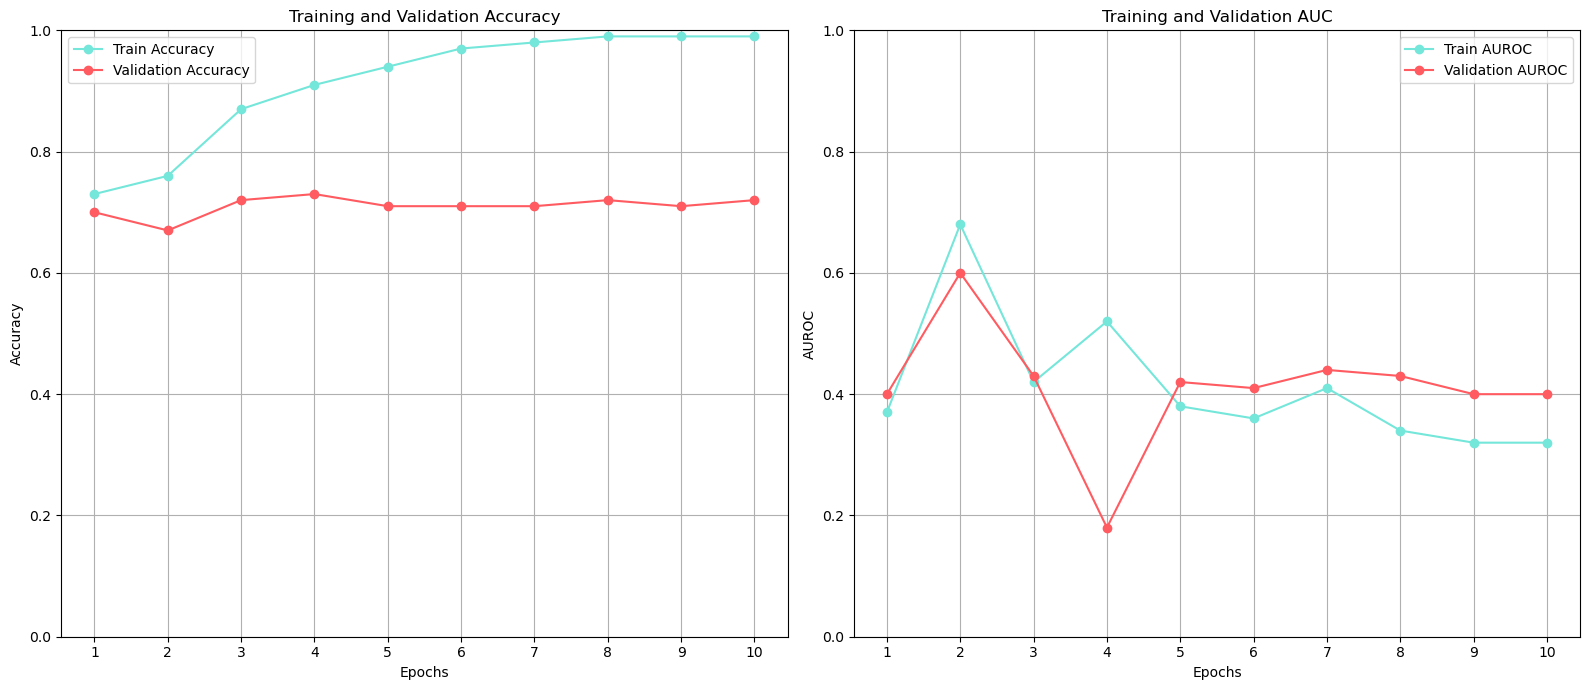

In [11]:
import matplotlib.pyplot as plt

# Plot size
plt.rcParams["figure.figsize"] = (16, 7)

# Plot for accuracies
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, label='Train Accuracy', marker='o', color='#75E6DA')
plt.plot(epochs, val_accs, label='Validation Accuracy', marker='o', color='#FF5B61')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Plot for AUCs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_aucs, label='Train AUROC', marker='o', color='#75E6DA')
plt.plot(epochs, val_aucs, label='Validation AUROC', marker='o', color='#FF5B61')
plt.title('Training and Validation AUC')
plt.xticks(epochs)
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('AUROC')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save the figure
plt.savefig('/new-stg/home/banghua/med264/acc_auroc.png', dpi=300)
plt.show()

In [25]:
import pickle
with open(preds_path+"/4/preds.pickle", "rb") as f:
    preds_results = pickle.load(f)

In [26]:
preds_results

{'train_preds': array([0, 0, 0, ..., 0, 1, 1]),
 'train_true_labels': array([0, 0, 0, ..., 0, 0, 1]),
 'val_preds': array([1, 0, 1, ..., 0, 0, 0]),
 'val_true_labels': array([1, 1, 1, ..., 0, 0, 0]),
 'test_preds': array([1, 1, 1, ..., 1, 1, 1]),
 'test_true_labels': array([1, 1, 1, ..., 0, 0, 0])}

In [28]:
test_preds = preds_results["test_preds"]
test_true = preds_results["test_true_labels"]

# Get the AUROC score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
print(roc_auc_score(test_true, test_preds))
print(f1_score(test_true, test_preds))
print(accuracy_score(test_true, test_preds))

0.7187307455329637
0.7489689304371735
0.7187307455329637
